In [1]:
pip install pandas torch transformers scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def clean_tweet(text):
    """Bersihkan tweet dari URL, mention, hashtag, emoji, dan karakter khusus."""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Hapus URL
    text = re.sub(r"@\w+", "", text)  # Hapus mention
    text = re.sub(r"#\w+", "", text)  # Hapus hashtag
    text = re.sub(r"[^\w\s]", "", text)  # Hapus tanda baca
    text = re.sub(r"\d+", "", text)  # Hapus angka
    text = text.lower().strip()  # Ubah ke huruf kecil dan hapus spasi berlebih
    return text

In [4]:
# --- Fungsi untuk Mendapatkan Embedding IndoBERT ---
def get_indobert_embedding(text, tokenizer, model, device):
    """Menghasilkan embedding IndoBERT untuk teks."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Ambil [CLS] token embedding


In [5]:
# --- Fungsi untuk Klasifikasi Tweet ---
def classify_tweet(tweet, stress_phrases, non_stress_phrases, tokenizer, model, device):
    """Klasifikasi tweet berdasarkan kemiripan dengan frasa stres/tidak stres."""
    cleaned_tweet = clean_tweet(tweet)
    if not cleaned_tweet:
        return "tidak_stres", 0.0  # Default jika tweet kosong setelah pembersihan

    # Dapatkan embedding tweet
    tweet_embedding = get_indobert_embedding(cleaned_tweet, tokenizer, model, device)

    # Dapatkan embedding frasa stres dan tidak stres
    stress_embeddings = [get_indobert_embedding(phrase, tokenizer, model, device) for phrase in stress_phrases]
    non_stress_embeddings = [get_indobert_embedding(phrase, tokenizer, model, device) for phrase in non_stress_phrases]

    # Hitung cosine similarity
    stress_similarities = [cosine_similarity(tweet_embedding, emb)[0][0] for emb in stress_embeddings]
    non_stress_similarities = [cosine_similarity(tweet_embedding, emb)[0][0] for emb in non_stress_embeddings]

    # Ambil similarity maksimum
    max_stress_sim = max(stress_similarities) if stress_similarities else 0
    max_non_stress_sim = max(non_stress_similarities) if non_stress_similarities else 0

    # Tentukan label berdasarkan similarity tertinggi
    if max_stress_sim > max_non_stress_sim:
        return "stres", max_stress_sim
    else:
        return "tidak_stres", max_non_stress_sim

In [6]:
# --- Setup IndoBERT ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

In [7]:
# Load the dataset
df_stress = pd.read_csv("dataset/real_dataset_stress.csv")

# Filter stress and non-stress phrases
stress_phrases = df_stress[df_stress["kategori"] == "stres"]["text"].tolist()
non_stress_phrases = df_stress[df_stress["kategori"] == "tidak_stres"]["text"].tolist()
df_stress.head(10)

,text,kategori
0,mau mati aja,stres
1,kenapa harus berusaha waktu kesepian,stres
2,kenapa harus ngerjain tugas waktu tekanan hidup,stres
3,bodoh banget kan jadi malu maluin,stres
4,capek banget jadi orang yang selalu tidur,stres
5,tiap malam cuma bisa memuaskan orang lain kare...,stres
6,rasanya pengen berpikir pas lagi masalah keluarga,stres
7,beneran gak kuat lagi buat menghindar,stres
8,muak jadi omongan orang,stres
9,udah nangis tapi tetap harapan palsu,stres


In [8]:
# --- Load Tweet dari CSV ---
file_path = "tweets-data/save_tweets.csv"
df_tweets = pd.read_csv(file_path)
df_tweets.head(10)

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1940350506007986530,Wed Jul 02 10:03:05 +0000 2025,0,jujur takut enih,1940350506007986530,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/194035050600798...,1865298251311910914,NaN
1,1940350437133336699,Wed Jul 02 10:02:48 +0000 2025,0,cuman masalah PC anying psslsllsls ke,1940350437133336699,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/194035043713333...,1865298251311910914,NaN
2,1940350382762574016,Wed Jul 02 10:02:35 +0000 2025,0,Kocakkk kenapa jadi ribet giniii,1940350382762574016,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/194035038276257...,1865298251311910914,NaN
3,1938612035983675410,Fri Jun 27 14:55:01 +0000 2025,0,Takuttt plss,1938612035983675410,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193861203598367...,1865298251311910914,NaN
4,1938611991679279512,Fri Jun 27 14:54:51 +0000 2025,0,Pusing mw osn,1938611991679279512,NaN,NaN,ht,NaN,0,0,0,https://x.com/undefined/status/193861199167927...,1865298251311910914,NaN
5,1938611958451937778,Fri Jun 27 14:54:43 +0000 2025,0,yeahhh baru bisa buka twt,1938611958451937778,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193861195845193...,1865298251311910914,NaN
6,1936296829089726653,Sat Jun 21 05:35:13 +0000 2025,0,Boiyen selalu ngakak plsss,1936296829089726653,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193629682908972...,1865298251311910914,NaN
7,1936270114204365041,Sat Jun 21 03:49:04 +0000 2025,0,Makan kueeee,1936270114204365041,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193627011420436...,1865298251311910914,NaN
8,1934992601670910189,Tue Jun 17 15:12:41 +0000 2025,0,apa dah dia sok pinter bet,1934992601670910189,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193499260167091...,1865298251311910914,NaN
9,1934630766048366790,Mon Jun 16 15:14:52 +0000 2025,0,Pusing banget ga bisa tidur plsss,1934630766048366790,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/193463076604836...,1865298251311910914,NaN


In [9]:
# --- Klasifikasi Tweet ---
results = []
for _, row in df_tweets.iterrows():
    tweet = row["full_text"]
    label, similarity = classify_tweet(tweet, stress_phrases, non_stress_phrases, tokenizer, model, device)
    results.append({
        "text": tweet,
        "cleaned_text": clean_tweet(tweet),
        "label": label,
        "similarity_score": similarity,
        "created_at": row["created_at"],
        "user_id": row["user_id_str"]
    })

In [ ]:
# Buat DataFrame dan simpan ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("hasil/tweet_stress_classification_results.csv", index=False)

In [11]:
# --- Hitung Kesimpulan Akhir ---
stress_count = len(df_results[df_results["label"] == "stres"])
total_tweets = len(df_results)
stress_percentage = (stress_count / total_tweets) * 100 if total_tweets > 0 else 0

In [12]:
# Tentukan kesimpulan
final_conclusion = "Stres" if stress_percentage >= 50 else "Tidak Stres"

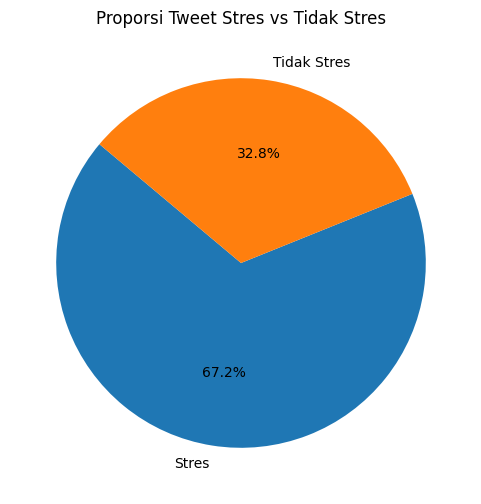

In [13]:
# --- Visualisasi Pie Chart ---
labels = ["Stres", "Tidak Stres"]
sizes = [stress_count, total_tweets - stress_count]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Proporsi Tweet Stres vs Tidak Stres")
plt.savefig("stress_pie_chart.png")
plt.show()

In [14]:
# --- Tampilkan Hasil ---
print(f"\nHasil Analisis Stres dari {total_tweets} Tweet:")
print(f"Jumlah Tweet Stres: {stress_count} ({stress_percentage:.2f}%)")
print(f"Jumlah Tweet Tidak Stres: {total_tweets - stress_count} ({100 - stress_percentage:.2f}%)")
print(f"Kesimpulan Akhir: {final_conclusion}")


Hasil Analisis Stres dari 61 Tweet:
Jumlah Tweet Stres: 41 (67.21%)
Jumlah Tweet Tidak Stres: 20 (32.79%)
Kesimpulan Akhir: Stres


In [15]:
df_results['clean_text'] = df_results['text'].apply(clean_tweet)

# Tampilkan semua hasil klasifikasi tweet stress
print("\nContoh Hasil Klasifikasi (Semua):")
for i, row in df_results.iterrows():
    print(f"Tweet: {row['clean_text']}")
    print(f"Label: {row['label']} (Similarity: {row['similarity_score']:.4f})")
    print("-" * 50)



Contoh Hasil Klasifikasi (Semua):
Tweet: jujur takut enih
Label: stres (Similarity: 0.9218)
--------------------------------------------------
Tweet: cuman masalah pc anying psslsllsls ke
Label: stres (Similarity: 0.8237)
--------------------------------------------------
Tweet: kocakkk kenapa jadi ribet giniii
Label: stres (Similarity: 0.9160)
--------------------------------------------------
Tweet: takuttt plss
Label: stres (Similarity: 0.8911)
--------------------------------------------------
Tweet: pusing mw osn
Label: stres (Similarity: 0.8481)
--------------------------------------------------
Tweet: yeahhh baru bisa buka twt
Label: stres (Similarity: 0.9046)
--------------------------------------------------
Tweet: boiyen selalu ngakak plsss
Label: stres (Similarity: 0.9276)
--------------------------------------------------
Tweet: makan kueeee
Label: stres (Similarity: 0.7846)
--------------------------------------------------
Tweet: apa dah dia sok pinter bet
Label: tidak_s